In [0]:
class util_vars:

    window_size=200
    forecast_window=10
    kernel_sz = 4
    nb_filter = 5
    dilation_rates = [2**i for i in range(8)]
    nb_epoch = 20
    batch_size = 500
    dense_activations = ['sigmoid','relu','relu','sigmoid','sigmoid']
    loss_functions = ['categorical_crossentropy', 'mse', 'mse', 'categorical_crossentropy', 'categorical_crossentropy']
    model_metrics = ['accuracy', 'mse', 'mse', 'accuracy', 'accuracy']
    output_sizes = [3,1,1,2,2]


    # Init
    def __init__(self):
        self.mean = np.arange(5)
        self.std = np.arange(5)


    def get_mean(self):
        return self.mean


    def set_mean(self, mean):
        self.mean = mean


    def get_std(self):
        return self.std


    def set_std(self, std):
        return self.std


    # Make time-series instance
    def make_timeseries_instances(self, timeseries, window_size, forecast_window):
        timeseries = np.asarray(timeseries)
        assert 0 < window_size < timeseries.shape[0]
        X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size-forecast_window, 1)]))
        y = timeseries[window_size:] # Change this if output size is to change too
        y = np.array([y[start:start+forecast_window] for start in range(0,y.shape[0]-forecast_window, 1)])
        q = np.atleast_3d([timeseries[-window_size:]])
        return X, y, q


In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image
%matplotlib inline
import math
util = None
util = util_vars()

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Reshape, Dropout, concatenate, GlobalMaxPooling1D
from keras.layers.wrappers import TimeDistributed
from keras.utils import plot_model

In [0]:
# Need to run in order to connect to google drive
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [90]:
normal_downloaded = drive.CreateFile({'id': '1rlunDfrtQb2_PdDijmswcdQf64UwAmTT'})
normal_downloaded.GetContentFile('swat_p1_normal.csv')

attack_downloaded = drive.CreateFile({'id': '1t32kesPMtv9PiOn1uOsODzAdV8u4IODz'})
attack_downloaded.GetContentFile('swat_p1_attack.csv')

# Read Data
dataset = pd.read_csv('swat_p1_normal.csv')
full_attack = pd.read_csv('swat_p1_attack.csv')
full_attack = full_attack.drop(full_attack.index[230310:264238]).reset_index(drop=True)
full_normal = dataset[['MV101', 'FIT101', 'LIT101', 'P101', 'P102']]
full_normal.head()

MV101    FIT101    LIT101  P101  P102
0      2  2.470294  261.5804     2     1
1      2  2.457163  261.1879     2     1
2      2  2.439548  260.9131     2     1
3      2  2.428338  260.2850     2     1
4      2  2.424815  259.8925     2     1

In [0]:
normal_data = full_normal.values[16000:, :].astype('float16') #Only need data after first 16,000
attack_data = full_attack.values[:, 1:].astype('float16')

In [92]:
normal_data.shape, attack_data.shape

((480800, 5), (415991, 5))

In [93]:
normal_data

array([[  1.   ,   0.   , 720.   ,   2.   ,   1.   ],
       [  1.   ,   0.   , 719.5  ,   2.   ,   1.   ],
       [  1.   ,   0.   , 719.5  ,   2.   ,   1.   ],
       ...,
       [  2.   ,   2.436, 523.   ,   2.   ,   1.   ],
       [  2.   ,   2.428, 523.   ,   2.   ,   1.   ],
       [  2.   ,   2.428, 523.   ,   2.   ,   1.   ]], dtype=float16)

In [94]:
attack_data

array([[  2.428, 523.   ,   2.   ,   2.   ,   1.   ],
       [  2.445, 523.   ,   2.   ,   2.   ,   1.   ],
       [  2.488, 523.   ,   2.   ,   2.   ,   1.   ],
       ...,
       [  2.531, 520.5  ,   2.   ,   2.   ,   1.   ],
       [  2.521, 520.5  ,   2.   ,   2.   ,   1.   ],
       [  2.502, 521.   ,   2.   ,   2.   ,   1.   ]], dtype=float16)

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

test_size = int(normal_data.shape[0]*0.5)

scaler = scaler.fit(normal_data[:-test_size,:])
normal_scaled = scaler.transform(normal_data)

In [0]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# test_size = int(normal_data.shape[0]*0.5)

# scaler = scaler.fit(normal_data[:-test_size,:])
# normal_scaled = scaler.transform(normal_data)

In [97]:
normal_scaled

array([[0.5    , 0.     , 0.707  , 1.     , 0.     ],
       [0.5    , 0.     , 0.705  , 1.     , 0.     ],
       [0.5    , 0.     , 0.705  , 1.     , 0.     ],
       ...,
       [1.     , 0.8877 , 0.11035, 1.     , 0.     ],
       [1.     , 0.885  , 0.11035, 1.     , 0.     ],
       [1.     , 0.885  , 0.11035, 1.     , 0.     ]], dtype=float16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f824cd8e080>,
      dtype=object)

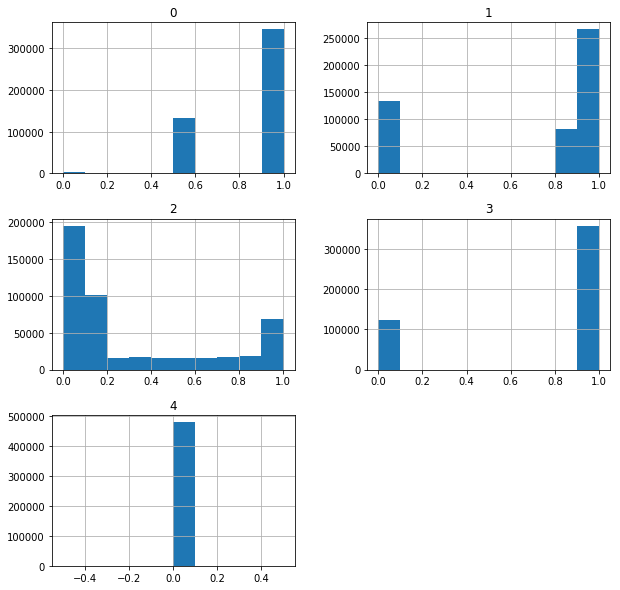

In [100]:
pd.DataFrame(normal_scaled).hist(figsize=(10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f824cb1e5f8>,
      dtype=object)

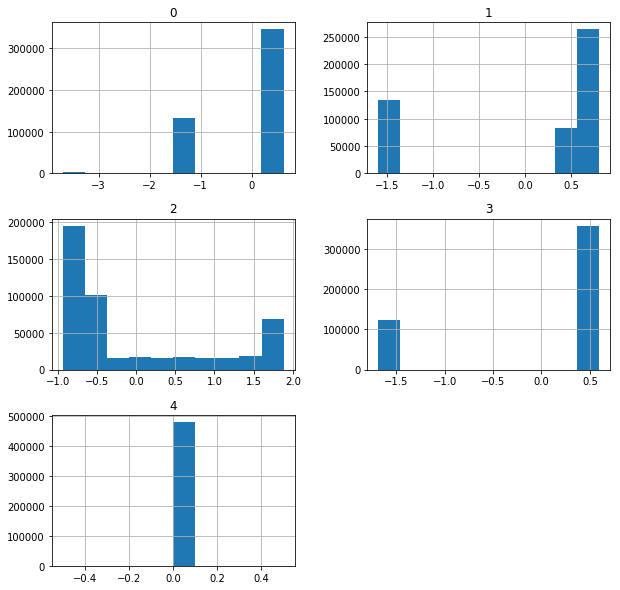

In [101]:
normal_downloaded = drive.CreateFile({'id': '1rlunDfrtQb2_PdDijmswcdQf64UwAmTT'})
normal_downloaded.GetContentFile('swat_p1_normal.csv')

attack_downloaded = drive.CreateFile({'id': '1t32kesPMtv9PiOn1uOsODzAdV8u4IODz'})
attack_downloaded.GetContentFile('swat_p1_attack.csv')

# Read Data
dataset = pd.read_csv('swat_p1_normal.csv')
full_attack = pd.read_csv('swat_p1_attack.csv')
full_attack = full_attack.drop(full_attack.index[230310:264238]).reset_index(drop=True)
full_normal = dataset[['MV101', 'FIT101', 'LIT101', 'P101', 'P102']]
full_normal.head()

normal_data = full_normal.values[16000:, :].astype('float16') #Only need data after first 16,000
attack_data = full_attack.values[:, 1:].astype('float16')

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

test_size = int(normal_data.shape[0]*0.5)

scaler = scaler.fit(normal_data[:-test_size,:])
normal_scaled = scaler.transform(normal_data)

pd.DataFrame(normal_scaled).hist(figsize=(10,10))

In [0]:
util.window_size = 200
util.forecast_window = 1
util.nb_filter = 5
util.nb_epoch = 100

In [103]:
windowed_X, windowed_y, windowed_q = util.make_timeseries_instances(normal_scaled, util.window_size, util.forecast_window)
windowed_X.shape, windowed_y.shape, windowed_q.shape

((480599, 200, 5), (480599, 1, 5), (1, 200, 5))

In [104]:
test_size = int(windowed_X.shape[0]*0.5)
X_train, X_test = normal_scaled[util.window_size+1:-test_size], normal_scaled[-test_size:]
test_size = int(windowed_X.shape[0]*0.5)
windowed_X_train, windowed_X_test = windowed_X[:-test_size], windowed_X[-test_size:]
X_train.shape, X_test.shape, windowed_X_train.shape, windowed_X_test.shape

((240300, 5), (240299, 5), (240300, 200, 5), (240299, 200, 5))

In [105]:
test_size = int(windowed_y.shape[0]*0.5)
windowed_y_train, windowed_y_test = windowed_y[:-test_size], windowed_y[-test_size:]
windowed_y_train.shape, windowed_y_test.shape

((240300, 1, 5), (240299, 1, 5))

In [106]:
validation_size = int(0.33*windowed_X_train.shape[0])
windowed_X_train, windowed_X_valid = windowed_X_train[:-validation_size], windowed_X_train[-validation_size:]
validation_size = int(0.33*windowed_y_train.shape[0])
windowed_y_train, windowed_y_valid = windowed_y_train[:-validation_size], windowed_y_train[-validation_size:] 
                                                                                         
validation_size = int(0.33*X_train.shape[0])
X_train, X_valid = X_train[:-validation_size], X_train[-validation_size:]
X_train.shape, X_valid.shape

((161001, 5), (79299, 5))

In [0]:
X_train_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_valid_t = X_valid.reshape(X_valid.shape[0], 1, X_valid.shape[1])

In [0]:
np.savez('windowed_data', windowed_X = windowed_X)

In [109]:
windowed_X_train.shape, windowed_y_train.shape, X_train_t.shape, X_valid_t.shape, windowed_X_valid.shape, windowed_y_valid.shape

((161001, 200, 5),
 (161001, 1, 5),
 (161001, 1, 5),
 (79299, 1, 5),
 (79299, 200, 5),
 (79299, 1, 5))

In [110]:
util.window_size, normal_data.shape[1]

(200, 5)

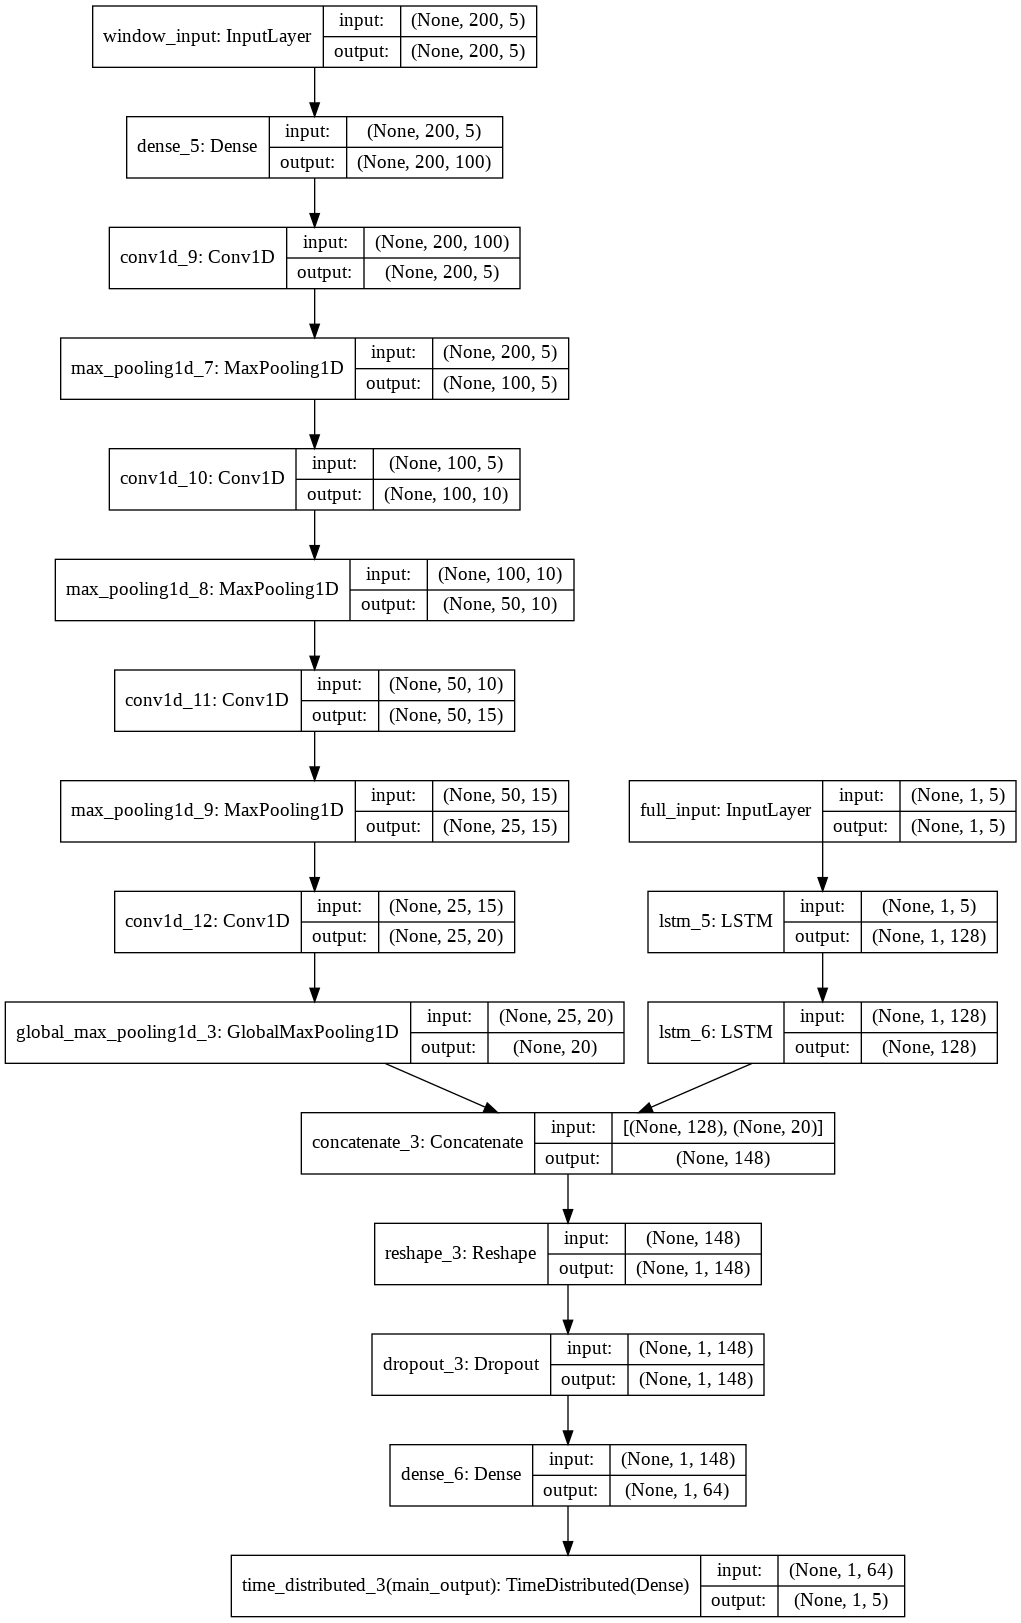

In [111]:
def multi_input(input_, full):
    x = Input(shape=(util.window_size, normal_data.shape[1]), name='window_input')
    
    cnn_out = Dense(100)(x)
    cnn_out = Conv1D(filters=util.nb_filter, kernel_size=4, activation='relu',
               padding='causal', dilation_rate=2)(cnn_out)
    cnn_out = MaxPooling1D()(cnn_out)
    cnn_out = Conv1D(filters=util.nb_filter*2, kernel_size=4, activation='relu',
               padding='causal', dilation_rate=4)(cnn_out)
    cnn_out = MaxPooling1D()(cnn_out)    
    cnn_out = Conv1D(filters=util.nb_filter*3, kernel_size=4, activation='relu',
               padding='causal', dilation_rate=8)(cnn_out)
    cnn_out = MaxPooling1D()(cnn_out)
    cnn_out = Conv1D(filters=util.nb_filter*4, kernel_size=4, activation='relu',
               padding='causal', dilation_rate=16)(cnn_out)
    cnn_out = GlobalMaxPooling1D()(cnn_out)
#     cnn_out = Conv1D(filters=util.nb_filter*5, kernel_size=4, activation='relu',
#                padding='causal', dilation_rate=16)(cnn_out)
#     cnn_out = GlobalMaxPooling1D()(cnn_out)
    
    # Non time-window input
    input_full = Input(shape=(1,full.shape[1]), name='full_input')
    lstm_out = LSTM(128, return_sequences=True)(input_full)
    lstm_out = LSTM(128)(lstm_out)
#     lstm_out = LSTM(util.nb_filter*4)(lstm_out)
    
    # Concat LSTM out and y
    y = concatenate([lstm_out, cnn_out])
    y = Reshape((1, 148))(y)
#     y = Reshape((int(util.nb_filter*4/normal_data.shape[1])*2,normal_data.shape[1]))(y)
    y = Dropout(0.2)(y)
#     y = TimeDistributed(Dense(normal_data.shape[1], activation='sigmoid', name='main_output'))(y)
    y = Dense(64, activation='sigmoid')(y)
    output = TimeDistributed(Dense(normal_data.shape[1], activation='sigmoid', name='main_output'))(y)

    model = Model(inputs=[x, input_full], outputs=output, name='cnn_lstm_model')
    return model


multi_model = multi_input(input_=windowed_X_train, full=X_train)
plot_model(multi_model, "test.png", show_shapes=True)
Image(retina=True, filename='test.png')

In [0]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

    
multi_model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=['mae'])

In [0]:
# Save model to disk
def save_model_to_disk(model_, name="model"):
    model_.save(name+'.h5')
    print("----- {0} SAVED TO DISK ----".format(name))

In [114]:
multi_model.fit({'window_input':windowed_X_train, 'full_input':X_train_t}, windowed_y_train, epochs=util.nb_epoch, 
              validation_data=([windowed_X_valid, X_valid_t], windowed_y_valid),batch_size=util.batch_size)

save_model_to_disk(multi_model, name="multi_model")

Train on 161001 samples, validate on 79299 samples
Epoch 1/100
161001/161001 [==============================] - 10s 65us/step - loss: 0.7684 - mean_absolute_error: 0.4780 - val_loss: 0.6441 - val_mean_absolute_error: 0.4165
Epoch 2/100
161001/161001 [==============================] - 8s 49us/step - loss: 0.7250 - mean_absolute_error: 0.4091 - val_loss: 0.6407 - val_mean_absolute_error: 0.4062
Epoch 3/100
161001/161001 [==============================] - 8s 49us/step - loss: 0.7224 - mean_absolute_error: 0.4024 - val_loss: 0.6399 - val_mean_absolute_error: 0.4042
Epoch 4/100
161001/161001 [==============================] - 8s 48us/step - loss: 0.7216 - mean_absolute_error: 0.4000 - val_loss: 0.6394 - val_mean_absolute_error: 0.4024
Epoch 5/100
161001/161001 [==============================] - 8s 48us/step - loss: 0.7213 - mean_absolute_error: 0.3988 - val_loss: 0.6392 - val_mean_absolute_error: 0.4018
Epoch 6/100
161001/161001 [==============================] - 8s 48us/step - loss: 0.7210

In [115]:
test_x = np.array([windowed_X_test[x] for x in range(0, windowed_X_test.shape[0], 10)])
test_y = np.array([windowed_y_test[x] for x in range(0, windowed_y_test.shape[0], 10)])
test_x.shape, windowed_X_test.shape, X_test.shape, windowed_y_test.shape, test_y.shape

((24030, 200, 5), (240299, 200, 5), (240299, 5), (240299, 1, 5), (24030, 1, 5))

In [0]:
test_x = windowed_X_test
test_y = windowed_y_test

In [0]:
predictions = multi_model.predict([test_x, X_test.reshape(X_test.shape[0], 1, X_test.shape[1])])

In [118]:
attack_data = scaler.transform(attack_data)
attack_windowed_X, attack_windowed_y, windowed_q = util.make_timeseries_instances(attack_data, window_size=util.window_size, forecast_window=util.forecast_window)
attack_full = attack_data[util.window_size:]
attack_windowed_X.shape, attack_windowed_y.shape, attack_full.shape

((415790, 200, 5), (415790, 1, 5), (415791, 5))

In [0]:
predictions_attack =  multi_model.predict([attack_windowed_X, attack_full.reshape(attack_full.shape[0], 1, attack_full.shape[1])])
error_attack = np.abs(predictions_attack - attack_windowed_y)

In [0]:
error_attack = error_attack.reshape(error_attack.shape[0], error_attack.shape[2])

In [121]:
predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1], predictions.shape[2])
test_y = test_y.reshape(test_y.shape[0]*test_y.shape[1], test_y.shape[2])
predictions.shape, test_y.shape

((240299, 5), (240299, 5))

In [0]:
error = np.abs(predictions - test_y)

In [0]:
mean_normal = np.mean(error, axis=0)
std_normal = np.std(error, axis=0)
# mean_attack = np.mean(errors_attack, axis=0)
# std_attack = np.std(errors_attack,axis=0)

In [124]:
mean_normal, std_normal

(array([4.3422970e-01, 4.4341373e-01, 5.7087976e-01, 4.1999179e-01,
        2.0964782e-05], dtype=float32),
 array([7.1444988e-01, 7.0405757e-01, 2.8148836e-01, 7.2594994e-01,
        9.0080102e-06], dtype=float32))

# CUSUM

In [0]:
from __future__ import division, print_function
import numpy as np

def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 9))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

In [0]:
test_alarm = np.zeros(error_attack[:,0].shape[0])

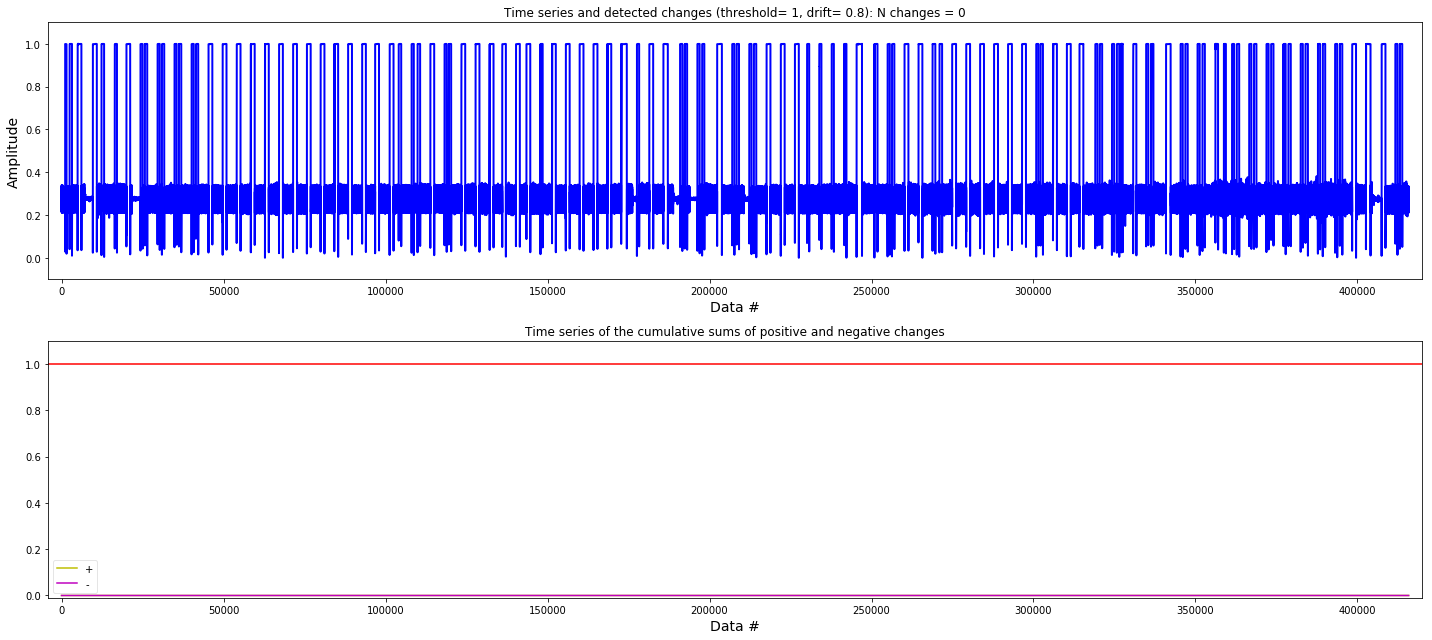

In [47]:
mv_alarm = detect_cusum(error_attack[:,0], threshold=1.0, drift=0.8, ending=False)[0]

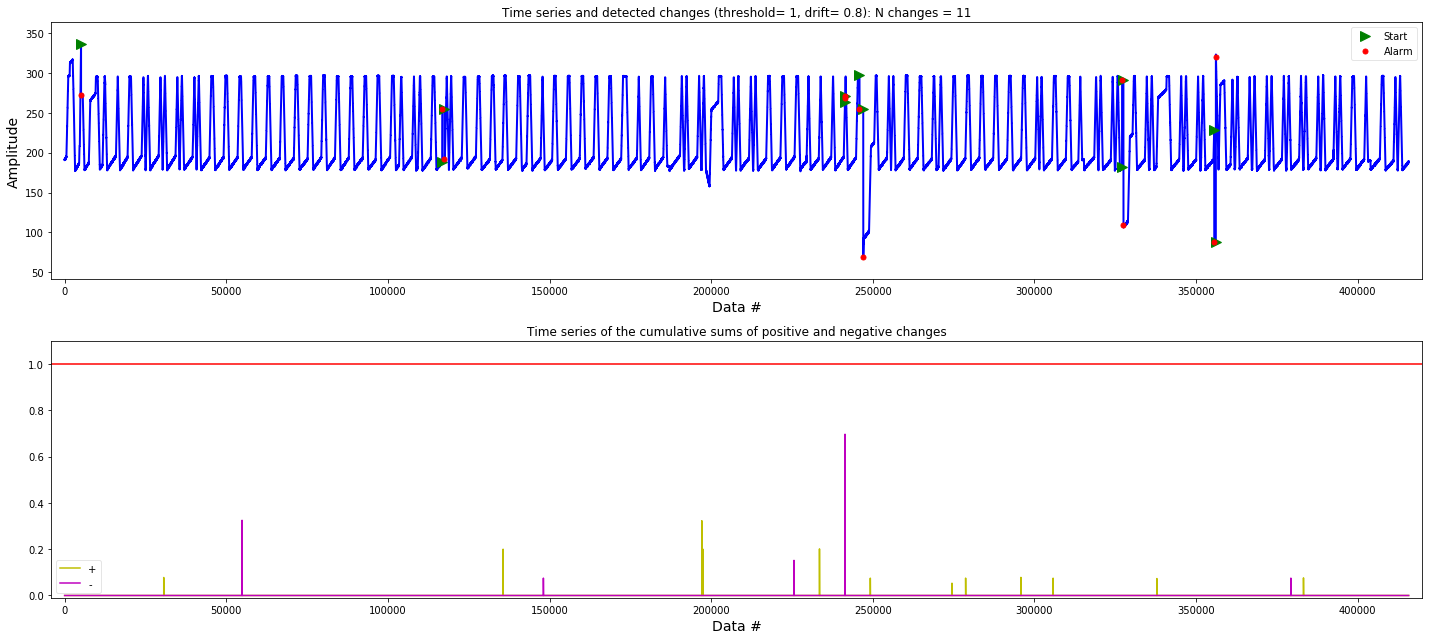

In [48]:
fit_alarm = detect_cusum(error_attack[:,1], threshold=1.0, drift=0.8, ending=False)[0]

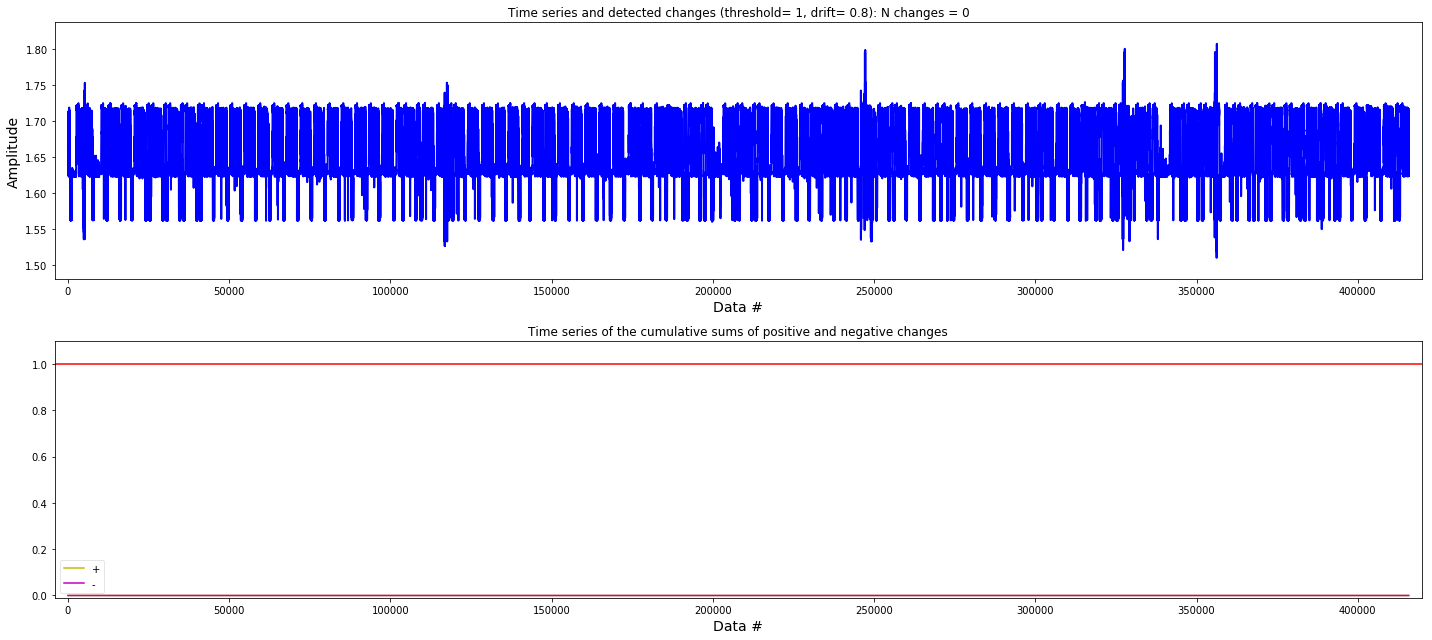

In [49]:
lit_alarm = detect_cusum(error_attack[:,2], threshold=1.0, drift=0.8, ending=False)[0]

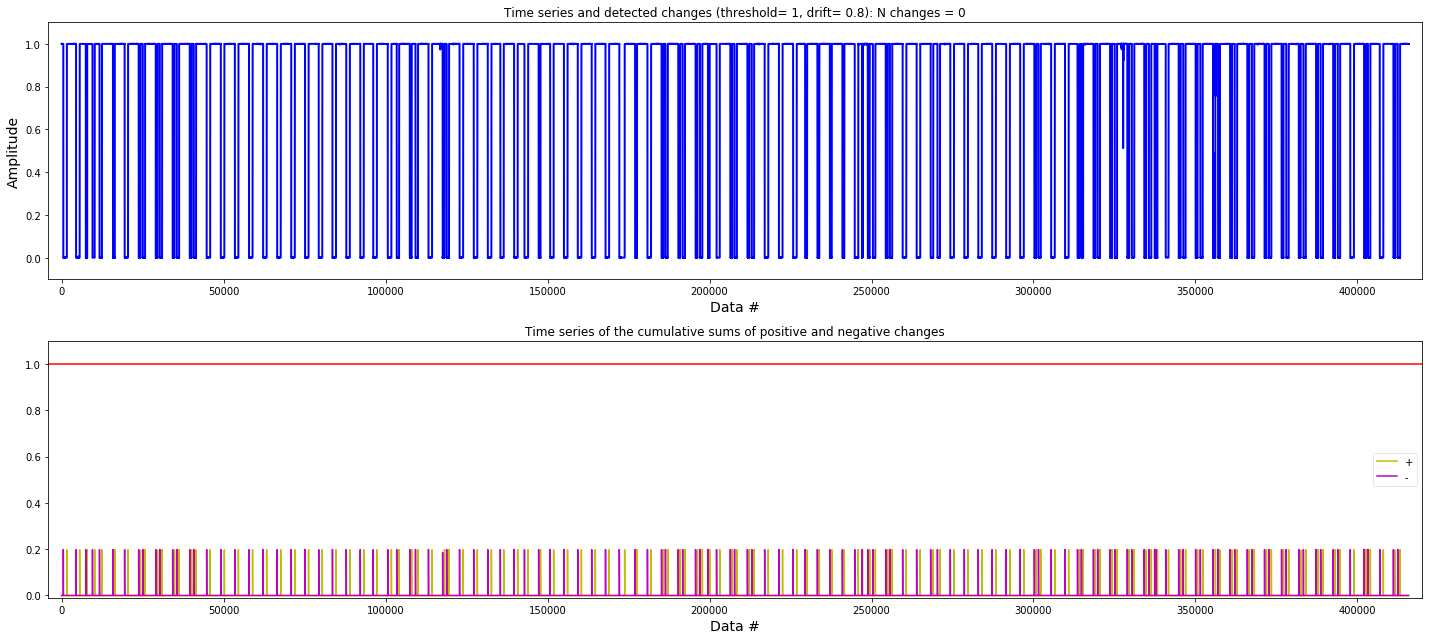

In [50]:
p_alarm = detect_cusum(error_attack[:,3], threshold=1.0, drift=0.8, ending=False)[0]

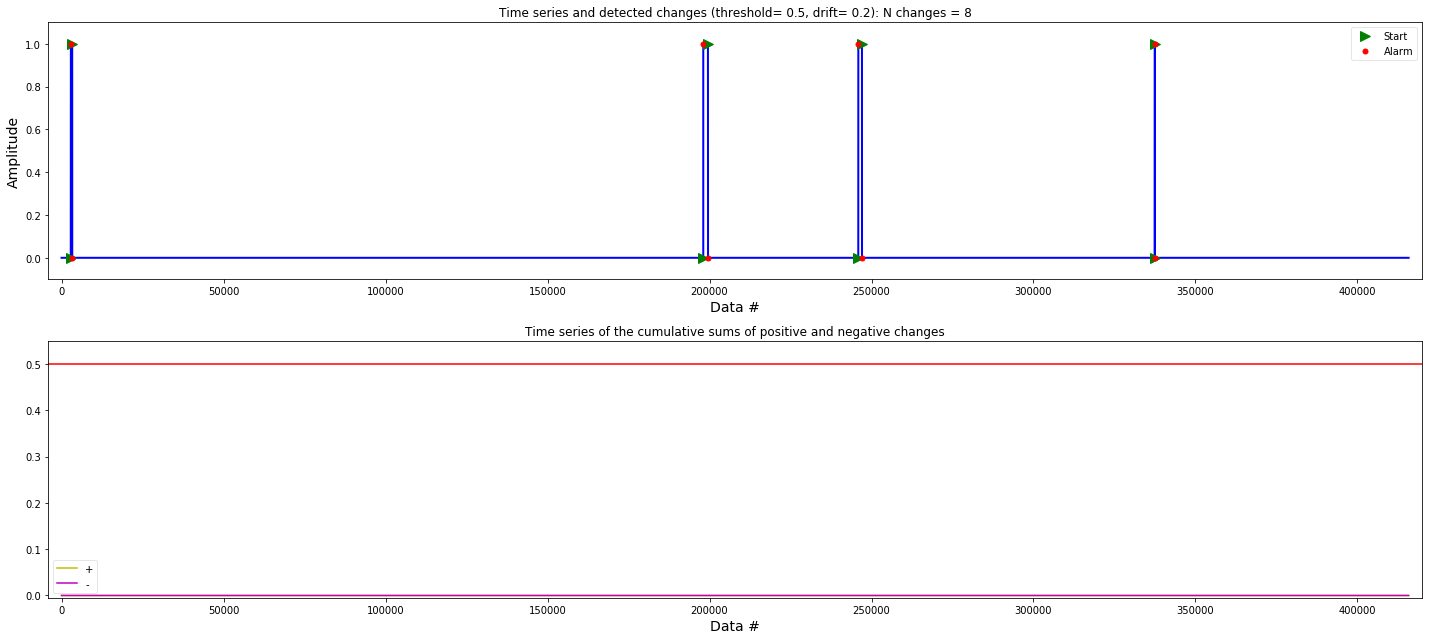

In [51]:
backup_alarm = detect_cusum(error_attack[:,4], threshold=0.5, drift=0.2, ending=False)[0]